In [125]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

              MTM   Open   High    Low     Vol. Change %
Date                                                    
2017-11-02  54.77  54.52  55.04  54.19  129.58K    0.48%
2017-11-03  55.86  54.92  55.97  54.63  137.71K    1.99%
2017-11-06  57.57  56.20  57.83  55.88  228.30K    3.06%
2017-11-07  57.43  57.49  57.90  57.06  248.34K   -0.24%
2017-11-08  57.05  57.22  58.14  56.65  325.03K   -0.66%


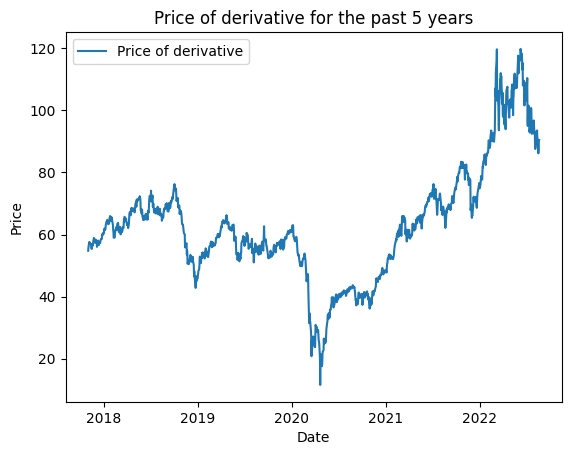

In [126]:
data = pd.read_csv('WTI Test.csv')

data['Date'] = pd.to_datetime(data['Date'], dayfirst=False)
data.set_index('Date', inplace=True)
data = data.sort_values('Date', ascending=True)

cutoff = '2017-11-01'

data = data[data.index > cutoff ]

print(data.head())

plt.plot(data.index, data['MTM'], label='Price of derivative')
plt.title('Price of derivative for the past 5 years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [127]:
data['Returns'] = (data['MTM'] - data['MTM'].shift(1)) / data['MTM'].shift(1)
data['Log_Returns'] = data['Returns'].apply(lambda x: np.log(1+x))
data.head()

,MTM,Open,High,Low,Vol.,Change %,Returns,Log_Returns
Date,,,,,,,,
2017-11-02,54.77,54.52,55.04,54.19,129.58K,0.48%,NaN,NaN
2017-11-03,55.86,54.92,55.97,54.63,137.71K,1.99%,0.019901,0.019706
2017-11-06,57.57,56.20,57.83,55.88,228.30K,3.06%,0.030612,0.030153
2017-11-07,57.43,57.49,57.90,57.06,248.34K,-0.24%,-0.002432,-0.002435
2017-11-08,57.05,57.22,58.14,56.65,325.03K,-0.66%,-0.006617,-0.006639


In [128]:
def create_scenario(no_of_points, dataframe, multiplier):
  daily_returns = dataframe['Log_Returns'].tolist()
  scenario = pd.Series(dtype=float)
  sum = 0
  for i in range(no_of_points):
    scenario[i] = np.random.choice(daily_returns) * multiplier
    sum += scenario[i]
  return np.var(scenario), sum


In [129]:
def create_scenario_optimized(no_of_points, dataframe, multiplier):
    rng = np.random.default_rng()
    returns = df['Log_Returns'].to_numpy(dtype=np.float64)

    samples  = rng.choice(returns, size=no_of_points)
    scaled   = samples * multiplier

    return np.var(scaled), scaled.sum()

In [130]:
def simulate(no_of_scenarios, no_of_points, dataframe, multiplier = 1):
  sum_list = pd.Series(dtype=float)
  for i in range(no_of_scenarios):
    sys.stdout.write(f'\rSimulations completed: {i + 1}/{no_of_scenarios}')
    sys.stdout.flush()
    var, sum = create_scenario(no_of_points, dataframe, multiplier)
    sum_list[i] = np.exp(sum - 0.5 * no_of_points * var)
  return sum_list

In [131]:
def simulate_optimized(no_of_scenarios, no_of_points, dataframe, multiplier = 1, chunk=None):
    rng      = np.random.default_rng()
    returns  = dataframe["Log_Returns"].to_numpy(dtype=np.float64, copy=False)

    if chunk is None or chunk >= no_of_scenarios:
        samples = rng.choice(returns,
                             size=(no_of_scenarios, no_of_points)) * multiplier
        sums = samples.sum(axis=1)
        vars = samples.var(axis=1)
        out  = np.exp(sums - 0.5 * no_of_points * vars)
        return pd.Series(out, index=range(no_of_scenarios))

    out   = np.empty(no_of_scenarios, dtype=np.float64)
    done  = 0
    while done < no_of_scenarios:
        n      = min(chunk, no_of_scenarios - done)
        block  = rng.choice(returns, size=(n, no_of_points)) * multiplier
        sums   = block.sum(axis=1)
        vars   = block.var(axis=1)
        out[done:done + n] = np.exp(sums - 0.5 * no_of_points * vars)

    return pd.Series(out, index=range(no_of_scenarios))

In [132]:
def identify_stress_benchmark(dataframe, rolling_period = 63, quantile = 0.95):
  rolling_std = dataframe['Log_Returns'].rolling(rolling_period).std()

  return rolling_std.quantile(quantile)

In [133]:
def calculate_scenarios(dataframe, stress_rolling_period = 63, chunk=50000, stress_quantile=0.95, no_of_points = 252, no_of_scenarios = 10000):
  list_of_simulations = simulate_optimized(no_of_scenarios, no_of_points, dataframe, chunk=chunk)

  unfavourable = list_of_simulations.quantile(0.1)
  moderate = list_of_simulations.quantile(0.5)
  favourable = list_of_simulations.quantile(0.9)

  print('Unfavourable: ', str(round((unfavourable - 1)*100, 2)), '%')
  print('Moderate: ', str(round((moderate - 1)*100, 2)), '%')
  print('Favourable: ', str(round((favourable - 1)*100, 2)), '%')

  stress_benchmark = identify_stress_benchmark(dataframe, stress_rolling_period, stress_quantile)

  stress_list_of_simulations = simulate_optimized(no_of_scenarios, no_of_points, dataframe, stress_benchmark/dataframe['Log_Returns'].std())

  stress = stress_list_of_simulations.quantile(0.05)

  print('\nStress: ', str(round((stress - 1) * 100, 2)), '%')

  return unfavourable, moderate, favourable, stress

In [143]:
scenarios = 10000
days_per_scenario = 252
stress_rolling_period = 63
stress_quantile = 0.95
chunk = None # If the program crashes from no memory, change to 100000.

scenarios = calculate_scenarios(data, no_of_scenarios=scenarios, no_of_points = days_per_scenario, stress_rolling_period = stress_rolling_period, stress_quantile=stress_quantile, chunk=chunk)

Unfavourable:  -57.56 %
Moderate:  -2.64 %
Favourable:  96.31 %

Stress:  -99.61 %
